In [1]:
import numpy as np
from astropy.io import fits
from numpy.lib.function_base import _calculate_shapes
import pandas as pd
import os
import math
from matplotlib import pyplot as plt

Mount google drive and set the path where our data is stored. We can also use local files but they are slower to upload

In [2]:
from google.colab import drive
drive.mount('/content/drive')

dir_path = "drive/MyDrive/Colab Notebooks/SKAData/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Get the fits file from the drive and extract the image

In [3]:
fits_img = fits.open(dir_path + "SKAMid_B1_8h_v3.fits")
print(fits_img.info())
fits_img = fits_img[0].data[0,0,:,:]
fits_img = fits_img[16350:,16350:]

Filename: drive/MyDrive/Colab Notebooks/SKAData/SKAMid_B1_8h_v3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     118   (32768, 32768, 1, 1)   float32   
None


Parameter settings:
since when using the entire image the RAM of the system fills easily, we can 

*   since, when using the entire image the RAM of the system fills easily, we can use the image_size variable to work only on a portion of the image
*   cutout_size is the size of the squares in which the image is divided


In [4]:
cutout_size = 218
#image_size = 32700
image_size = 15260
cutouts_per_row = image_size//cutout_size

Divide the image

In [5]:
cutouts = np.empty((cutouts_per_row**2,cutout_size,cutout_size))

for i in range(0,cutouts_per_row):
  for j in range(0,cutouts_per_row):
    cutouts[i*cutouts_per_row+j] = fits_img[i*cutout_size:i*cutout_size+cutout_size,j*cutout_size:j*cutout_size+cutout_size]

del fits_img

In [6]:
for i in range(len(cutouts)):
  f = cutouts[i].flatten()
  avg = np.mean(f)
  std = np.std(f)
  cutouts[i] = (cutouts[i] - avg) / std

Upload the already filtered training set from the drive

In [7]:
FilteredTrainingSet=pd.read_csv(dir_path + "new_filtered_training_set.csv",)
#FilteredTrainingSet=pd.read_csv(dir_path + "TrainingSet_B1_v2.txt",skiprows=17,delimiter='\s+')
FilteredTrainingSet=FilteredTrainingSet[FilteredTrainingSet.columns[0:15]]
FilteredTrainingSet.columns=['ID','RA (core)','DEC (core)','RA (centroid)','DEC (centroid)','FLUX','Core frac','BMAJ','BMIN','PA','SIZE','CLASS','SELECTION','x','y']
FilteredTrainingSet['x']=FilteredTrainingSet['x'].astype(int)
FilteredTrainingSet['y']=FilteredTrainingSet['y'].astype(int)
FilteredTrainingSet['x']=FilteredTrainingSet['x']-16350
FilteredTrainingSet['y']=FilteredTrainingSet['y']-16350
FilteredTrainingSet = FilteredTrainingSet.set_index('ID')
print(np.min(FilteredTrainingSet['y']),np.max(FilteredTrainingSet['y']),np.min(FilteredTrainingSet['x']),np.max(FilteredTrainingSet['x']))

382 3570 33 3520


Generate images from the training set where each dot corresponds to a source

In [8]:
data=np.zeros((image_size,image_size), dtype=np.uint8 )
for i in range(0,len(FilteredTrainingSet)):
	    data[int(FilteredTrainingSet['y'].iloc[i]),int(FilteredTrainingSet['x'].iloc[i])] = 1

Divide the data generated images

In [9]:
data_array = np.empty((cutouts_per_row**2,cutout_size,cutout_size))

for i in range(0,cutouts_per_row):
  for j in range(0,cutouts_per_row):
    data_array[i*cutouts_per_row+j] = data[i*cutout_size:i*cutout_size+cutout_size,j*cutout_size:j*cutout_size+cutout_size]

del data

In [10]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import regularizers

In [11]:
train_x, test_x, train_y, test_y = train_test_split(cutouts, data_array, test_size=0.25, random_state=42,shuffle=True)
del cutouts
del data_array
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.25, random_state=42,shuffle=True)

Define the model

In [12]:
input_layer = Input(shape=(cutout_size, cutout_size, 1))
x = Conv2D(16, (7, 7), strides=1, activation='relu', padding='same')(input_layer)
#x = BatchNormalization()(x)
x = Conv2D(32, (5, 5), strides=1, activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
output_layer = Dense(1,activation='sigmoid')(x)

myCNN = Model(input_layer,output_layer)
adadelta = optimizers.Adadelta(learning_rate=1.0, decay=0.0, rho=0.99)
myCNN.compile(optimizer=adadelta, loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

print(myCNN.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 218, 218, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 218, 218, 16)      800       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 218, 218, 32)      12832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 218, 218, 64)      18496     
_________________________________________________________________
dense (Dense)                (None, 218, 218, 1)       65        
Total params: 32,193
Trainable params: 32,193
Non-trainable params: 0
_________________________________________________________________
None


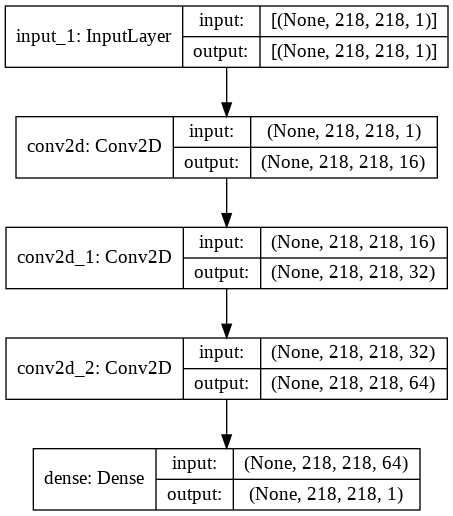

In [13]:
from tensorflow.keras.utils import plot_model

plot_model(myCNN,show_shapes=True)

Training of our model

In [14]:
batch_size = 32

In [15]:
base_history = myCNN.fit(train_x, train_y, epochs=10, batch_size=batch_size, shuffle=True, validation_data=(val_y, val_y), verbose=1, callbacks=[es, cp])

Epoch 1/10
87/87 [==============================] - 866s 10s/step - loss: 0.0225 - accuracy: 0.9898 - val_loss: 0.0476 - val_accuracy: 0.9999

Epoch 00001: val_loss improved from inf to 0.04761, saving model to best_model.hdf5
Epoch 2/10
87/87 [==============================] - 870s 10s/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 0.0221 - val_accuracy: 0.9999

Epoch 00002: val_loss improved from 0.04761 to 0.02207, saving model to best_model.hdf5
Epoch 3/10
87/87 [==============================] - 867s 10s/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.0146 - val_accuracy: 0.9999

Epoch 00003: val_loss improved from 0.02207 to 0.01460, saving model to best_model.hdf5
Epoch 4/10
87/87 [==============================] - 861s 10s/step - loss: 0.0013 - accuracy: 0.9999 - val_loss: 0.0105 - val_accuracy: 0.9999

Epoch 00004: val_loss improved from 0.01460 to 0.01048, saving model to best_model.hdf5
Epoch 5/10
87/87 [==============================] - 852s 10s/step - loss: 0.0012

In [16]:
myCNN.save('base_model.h5')

In [17]:
print(base_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [18]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

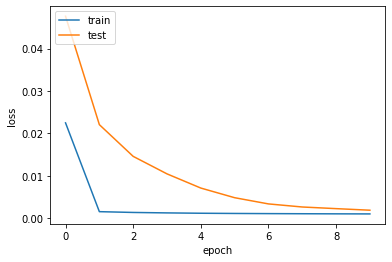

In [19]:
plot_history(base_history,['loss','val_loss'])

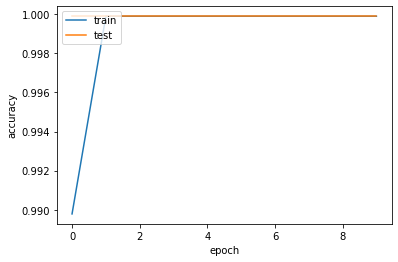

In [20]:
plot_history(base_history,['accuracy','val_accuracy'])

**Performance evaluation**

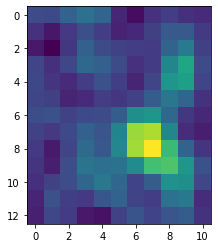

[[ 1.45624717e-01  3.48722869e-02  8.07933322e-01  1.26971380e+00
   8.90767814e-01 -8.63994941e-01 -1.47048435e+00 -5.95672776e-01
  -2.71241837e-01 -6.15615515e-01 -7.78935752e-01]
 [-5.95868595e-01 -1.21473934e+00 -3.90168724e-01  2.22814370e-01
  -2.73540175e-01 -9.31802437e-01 -7.89752554e-01 -2.16982257e-01
   5.08487561e-01  5.24894055e-01 -3.60429880e-01]
 [-1.19110391e+00 -1.73413640e+00 -4.22143075e-01  7.45037954e-01
   1.35565782e-01 -1.68117371e-01 -2.67423480e-01 -3.28434106e-01
   8.27446667e-01  1.60670540e+00 -1.96149348e-01]
 [-4.52937501e-02 -6.44118427e-01 -2.69172352e-02  9.66380394e-01
   7.52808359e-01  1.44695936e-01 -5.89949258e-01 -3.39668152e-01
   1.97537404e+00  3.01761910e+00  1.37563999e-01]
 [ 2.16966259e-03 -5.33190200e-01 -7.55051542e-01 -2.60441871e-01
   2.68023580e-01 -2.47236587e-01 -9.02115042e-01 -3.94138786e-02
   2.48088386e+00  2.80850094e+00 -4.89323681e-02]
 [-5.71041717e-02 -1.99572034e-01 -8.83863504e-01 -7.76560024e-01
  -2.53941741e-01 -

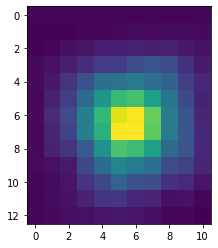

[[0.00464152 0.00464152 0.00464152 0.00464152 0.00464152 0.00464152
  0.00464152 0.00464152 0.00464152 0.00464152 0.00464152]
 [0.00460842 0.00462133 0.00462479 0.00467643 0.00465697 0.00472099
  0.00482319 0.00477718 0.00482756 0.00482865 0.00475263]
 [0.00461042 0.00468753 0.00486975 0.00500014 0.00520345 0.00526874
  0.00537058 0.00525528 0.00529002 0.00512234 0.00494376]
 [0.00473499 0.00495031 0.00524764 0.00564627 0.00601599 0.00605127
  0.00653119 0.00679251 0.00652027 0.00576921 0.00517563]
 [0.004761   0.00514108 0.00589014 0.00672741 0.00778672 0.00782564
  0.00820099 0.0077549  0.00726152 0.0061151  0.00554752]
 [0.00472844 0.00532311 0.00620093 0.00753449 0.00913409 0.01051038
  0.01075461 0.00948198 0.00791166 0.00646572 0.00541259]
 [0.00473645 0.00556116 0.00657738 0.00833156 0.01040218 0.01295307
  0.01325768 0.01128363 0.008275   0.00689435 0.00547842]
 [0.0047139  0.0054255  0.00633878 0.00833665 0.01011284 0.01329806
  0.01333679 0.01115797 0.0081428  0.00692218 0.00

In [33]:
plt.imshow(test_x[12][32:45,37:48])
plt.show()

print(test_x[12][32:45,37:48])

t = myCNN.predict(test_y[12:13])


f = t[0,:,:,0].flatten()
avg = np.mean(f)
std = np.std(f)
max = np.max(f)
t = (t[0,:,:,0] / max)

plt.imshow(t[32:45,37:48])
plt.show()

print(t[32:45,37:48])


In [22]:
train_y_pred = myCNN.predict(train_x)
val_y_pred = myCNN.predict(val_x)
test_y_pred = myCNN.predict(test_x)

print('Train predictions shape: ',train_y_pred.shape)
print('Validation predictions shape: ',val_y_pred.shape)
print('Test predictions shape: ',test_y_pred.shape)

Train predictions shape:  (2756, 218, 218, 1)
Validation predictions shape:  (919, 218, 218, 1)
Test predictions shape:  (1225, 218, 218, 1)
